# Para aumentar o display do Pandas

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 3554)

# Para resetar todas as configurações do Pandas:

In [ ]:
import pandas as pd
pd.reset_option('all')

# Condições base da competição
A princípio precisamos estabelecer as condições base às quais o foguete estava submetido durante a coleta de dados


### 1) Environment
-Sabemos que a data de lançamento do foguete foi:

    Data: 08/11/2025

-Analisando a 6th Space Challenge, sabemos que para esse ano o local de lançamento foi num novo lugar, o "Sugarcane Launch Range" em "Lacanga - SP", obtendo as coordenadas pelo Google Maps temos:

    Latitude: -21.938700249834092
   
    Longitude: -48.950450497781446

- Para a altitude foi utilizado o site https://contourmapcreator.urgr8.ch/ para extrair o mapa topográfico da região.
A área selecionada foi um quadrado com as extremidades (latitude, longitude):
Vértice Superior-Esquerdo: -21.937621811402707, -48.951870203018196
Vértice Inferior-Direita:-21.940040120354265, -48.94905924797059

Foi obitido a seguinte altitude média na região de lançamento em relação ao nível do mar:

    Altitude: 490m

![Mapa topológico - Sugarcane Launch Range - Lacanga - SP.png](<attachment:Mapa topológico - Sugarcane Launch Range - Lacanga - SP.png>)

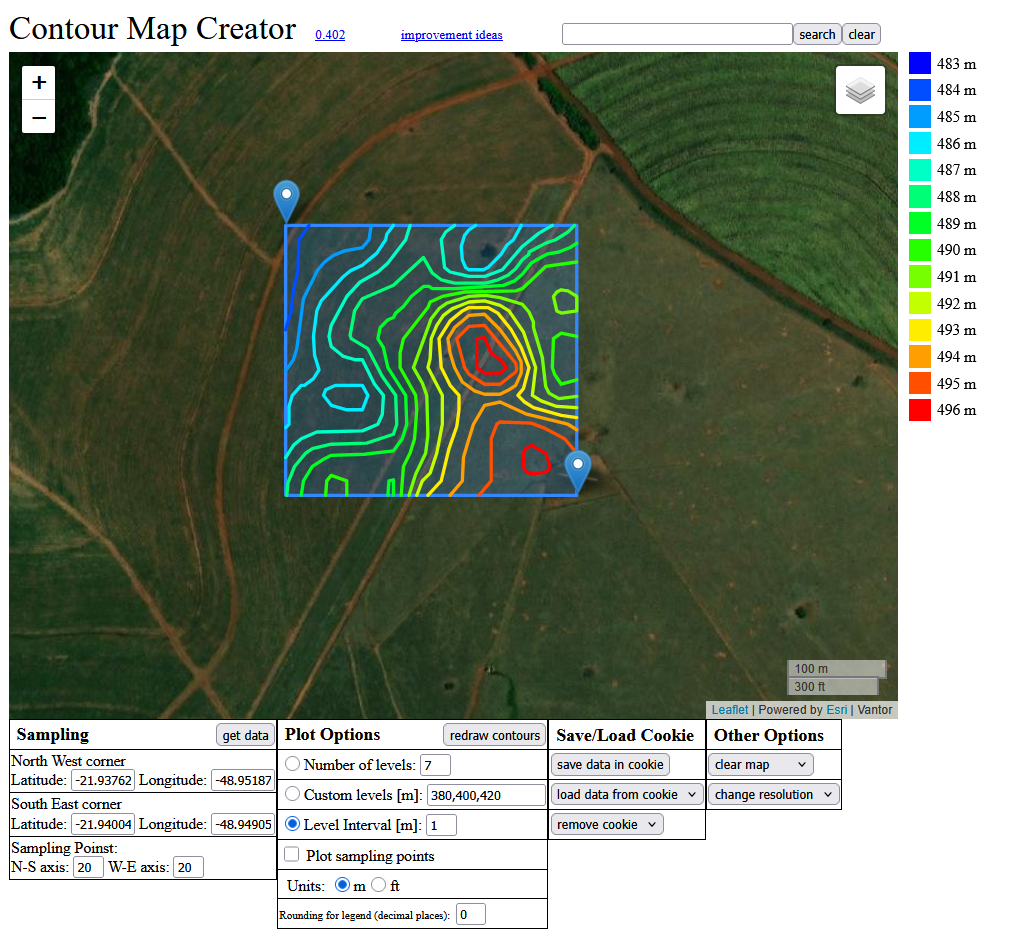

# Análise de dados Nashira

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### Transformando CSV em dataframe

In [ ]:
df = pd.read_csv("nashira_telemetry.csv", decimal = ",")
timestamp = df.columns[0] #primeira coluna
df.set_index(timestamp) #indexamos para realizar buscas
df.columns = [x.lower() for x in df.columns] #formata todas as colunas para minúsculo
df

df.head()

### Removendo colunas vazias

- As colunas de validação (imu_valid, ekf_valid, etc) não tem nenhum dado em todo o CSV por isso serão droppadas

In [ ]:
colunas_para_checar = df.columns[32:37] #vamos ver se as colunas da 32 à 37 estão totalmente vazias
for col in colunas_para_checar:
    if df[col].isna().all():
        df = df.drop(columns=col,axis= "columns") #se estiverem vazias droppa as colunas

df.head()

### Checagem do GPS

- Para simplificar vou criar uma coluna auxiliar à gnss_fix, onde ela indicará apenas se há sinal de gps (1) ou se não há (0)

In [ ]:
df['gps_available'] = df['gnss_fix'] > 0

### Formatação dos timestamps

- Para simplificar a leitura vamos usar o intervalo de tempo do lançamento ao invés das timestamps nos gráficos

In [ ]:
df['time_interval'] = df['timestamp_ms'] - df['timestamp_ms'][0]

In [ ]:
df.tail()

### Análise da altitude

- Temos os dados da altitude do GPS e a do Barômetro. Vamos plottar ambos e identificar se há inconsistência na medição de alguma

- Agora, iremos separar os plots com base no flight state e considerar o TEMPO DECORRIDO e a ALTITUDE GANHA desde o ínicio do STATE, para podermos analisar a variação da altitude em função do tempo

In [ ]:
states = df["flight_state"].unique()
n_states = len(states) #sabemos que temos 4 flight_states [1,2,3,5]

figure, axes = plt.subplots(n_states,2, figsize=(16,4*n_states)) #Teremos 2 gráficos (GPS e BAR) por "linha", cada linha representa 1 state

for i, state in enumerate(states):
    df_state = (df[df["flight_state"] == state]).copy() #Vamos alterar por referência, então por garantia usamos uma cópia
    df_state = df_state.sort_values("time_interval")
    start_time = df_state["time_interval"].iloc[0]
    df_state["time_from_start"] = (df_state["time_interval"] - start_time)

    df_gps_off_state = (df_state[df_state["gps_available"] == 0]).copy() #pontos em que não há sinal de GPS

    #Coluna 1 - GPS
    axes[i,0].plot(df_state["time_from_start"], df_state["alt_gps"], color ="r", linestyle="-",label ="GPS", alpha = 0.7, linewidth = 1)
    if len(df_gps_off_state) > 0: #Se houver ponto onde o GPS não funcionou
        axes[i,0].scatter(df_gps_off_state["time_from_start"], df_gps_off_state["alt_gps"], color ="#90D5FF", label="GPS OFF", zorder=1)

    axes[i,0].set_title(f"Altitude GPS - Flight State {state}", fontsize = 14)
    axes[i,0].set_xlabel('Tempo desde o início do state (ms)', fontsize = 12)
    axes[i,0].set_ylabel('Altitude(m)', fontsize = 12)
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.5)

    #Ajusta o tamanho do eixo x
    time_max = df_state["time_from_start"].max()
    axes[i,0].set_xlim(-0.01*time_max,1.01*time_max) #Coloca um padding nas laterais do gráfico

    #Coluna 2 - BAR
    axes[i,1].plot(df_state["time_from_start"], df_state["alt_bar"], color ="g", linestyle="-",label ="BAR", alpha = 0.7, linewidth = 1)
    axes[i,1].set_title(f"Altitude Barométrica - Flight State {state}", fontsize = 14)
    axes[i,1].set_xlabel('Tempo desde o início do state (ms)', fontsize = 12)
    axes[i,1].set_ylabel('Altitude(m)', fontsize = 12)
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.5)

        #Ajusta o tamanho do eixo x
    time_max = df_state["time_from_start"].max()
    axes[i,1].set_xlim(-0.01*time_max,1.01*time_max)

plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

### Pontos de destaque
- Note que houve uma perda de conexão com o GNSS na fase 5
- É preciso tratar os ruídos que estão distorcendo o eixo Y na fase 1 e 5 (sugestão de usar Savitzky-Golay)


* Analisando discrepâncias das medidas do GPS e BAR

Vamos plottar um gráfico do "offset" entre as medidas do GPS e do Barômetro

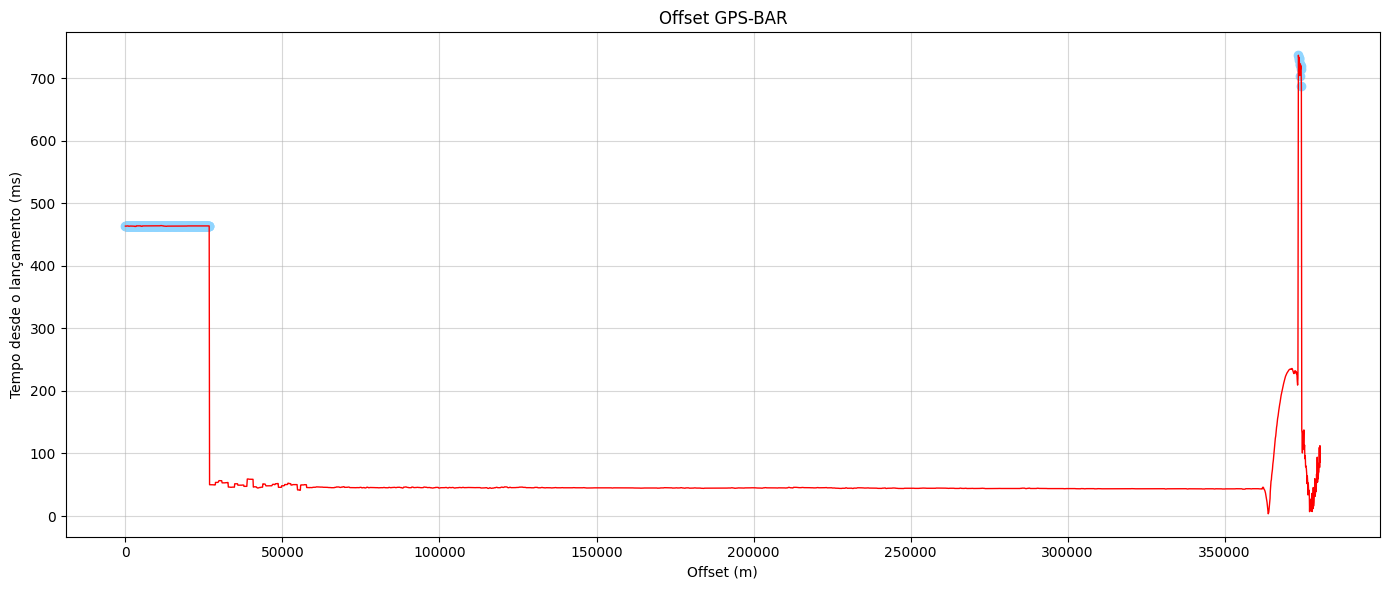

In [20]:
df_offset = df[["time_interval","alt_gps", "alt_bar", "gps_available"]].copy()

df_offset[["alt_gps", "alt_bar"]] = df_offset[["alt_gps", "alt_bar"]].astype("float32")
df_offset["offset"] = (abs(df_offset["alt_bar"] - df_offset["alt_gps"]))

plt.figure(figsize=(14,6))
#Plot do Offset
plt.plot(df_offset["time_interval"], df_offset["offset"],color ="r", linestyle="-", linewidth = 1) 

#Plot dos pontos com GPS off
df_gps_off = (df_offset[df_offset["gps_available"] == 0])
plt.scatter(df_gps_off["time_interval"], df_gps_off["offset"], color ="#90D5FF", label="GPS OFF", zorder=1)

plt.title("Offset GPS-BAR")
plt.xlabel("Offset (m)")
plt.ylabel("Tempo desde o lançamento (ms)")

plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
df_offset

Note que o OFFSET tem um comportamento constante (ideal) em boa parte do tempo em que o GPS funciona - isso indica que nossas medições de altitude por bar e pelo GPS podem ser usadas em conjunto para estimar dados quando o offset é considerado

Além disso, note que a partir de ~36000ms o offset passa a ter grande variações antes do GPS perder o sinal, o que torna essa região de medição menos confiável. Ao analisar as altitudes do GPS e Barômetro separadamente (gráfico já mostrado anteriormente) percebemos que o GPS trava numa medição durante alguns milissegundos. Assim podemos afirmar que o barômetro é mais confiável nesse intervalo

Após o GPS recuperar o sinal o offset continua aumentando - COLOCAR A MEDIDA DE PRESSÃO NO GRÁFICO DE ALT_GPS X ALT_BAR

-MARCAR NOS GRÁFICOS: APOGEU (MAIOR ALTITUDE), BURNOUT(ACCEL = 0, VEL CAI, FLIGHT_STATE MUDA), LANDING(ALTITUDE RELATIVA PROX À 0)